# Single target regression from ROOT file

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

In [2]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from ROOT file 
Use uproot to import the ROOT data into a pandas dataframe.
Example data is for the process $pp\rightarrow hh\rightarrow b\bar{b}\,\tau\bar{\tau}\rightarrow b\bar{b}\,\tau_h\mu$

In [3]:
import uproot
df = uproot.open(PATH/'signal.root')['tree'].pandas.df()

In [4]:
df.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1.0,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1.0,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1.0,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1.0,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1.0,1.0


Since only the $\mu+\tau_h$ decay channel is used, $t_1$ has a constant mass (muon mass), so we can simply drop it.

In [5]:
df.drop(columns=['t_1_mass'], inplace=True)

The data also contains events where the incorect final-states were chosen, since we need the reconstructed and generator-level objects to match for correct regression, we only want to train on the correctly selected events (gen_mctMatch == True)

In [6]:
df = df[df.gen_mctMatch == 1]; len(df)

61405

We can now check how poorly the reconstructed di-Higgs mass matches to the true mass

In [7]:
df['gen_delta'] = df['diH_mass']-df['gen_diH_mass']

`plot_feat` is a flexible function to provide indicative information about the 1D distribution of a feature. By default it will produce a weighted KDE+histogram for the [1,99] percentile of the data, as well as compute the mean and standard deviation of the data in this region. 

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


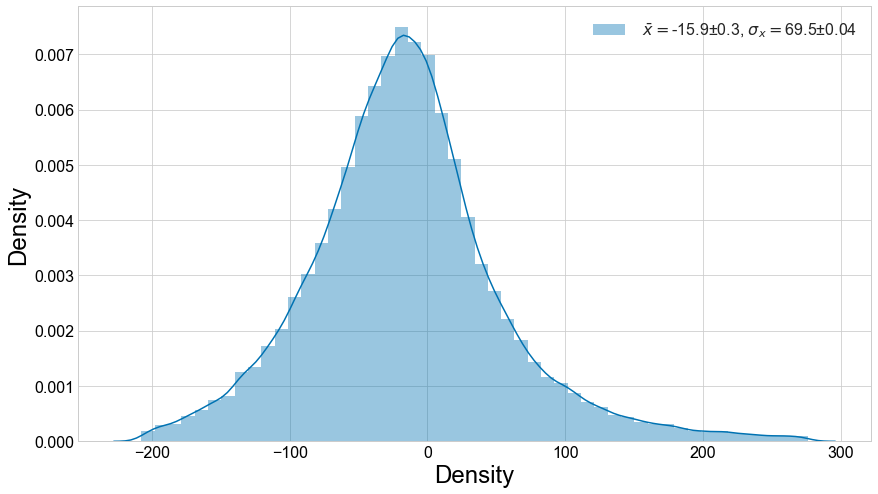

In [8]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(df, 'gen_delta')

### Preprocessing
Having imported the ROOT data, we now need to further process it into form suitable for training the regressor.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is higly non-linear. Additionally, since the di-Higgs mass is invarient under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation.

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positve $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

In [ ]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='t_0', ref_vec_1='t_1', keep_feats=['mPT_pT'])

For quick access, we'll define here all the sets of features we'll later want use

In [ ]:
targ_feat = 'gen_diH_mass'
gen_feats = [f for f in df.columns if 'gen_' in f]
cat_feats = [f for f in df.columns if f.startswith('n') if f != 'nPhotons']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

Several of the categorical features display long tails, making it difficult to ensure decent population. We're perhaps more interest in whether events contain few, several, or lots of jets, rather that the exact number, so we'll simply cut to the tails and more the last category to be $x$ or greater.

In [ ]:
df.loc[df.nJets >= 5, 'nJets'] = 4
df.loc[df.nBJets >= 5, 'nBJets'] = 4
for f in cat_feats:
    s = set(df[f])
    print(f, len(s), s)

To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [ ]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[cat_feats].values)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df.columns[df.isna().any()].tolist()

#### Train-validation split 

In [ ]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [ ]:
from lumin.utils.data import check_val_set
check_val_set(train_df, val_df)

#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [ ]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH)

In [ ]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [ ]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df)
cat_maps, cat_szs

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [ ]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

In [ ]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

## Feature selection

Currently we're using all of the available information from the ROOT file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and deporcess it my adding the input pipe.

In [ ]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

[Description of dendrogram]

In [ ]:
from lumin.plotting.data_viewing import plot_dendrogram
plot_dendrogram(train_df[train_feats])

For further tests we'll want to split of another, temporary validation set

In [ ]:
df_trn, df_val = train_test_split(train_df, test_size=0.8)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not beable to make as much use of the loweer level information as the neural networks will, so we'll only test the high level fetaures and add regularisation as necessary leter.

In [ ]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats), vec_feats

In [ ]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats), hl_feats

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and eveluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the fetaures and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important.

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

In [ ]:
from lumin.optimisation.features import *
import_feats = rf_rank_features(df_trn, df_val, objective='regression', train_feats=hl_feats, cut=0.001)

In [ ]:
_, m = get_opt_rf_params(df_trn[import_feats], df_trn.gen_target, df_val[import_feats], df_val.gen_target, objective='regression')

The above method of premutation importance, does not account for the possibility of r sets of features being coreallated; features carrying mutual information can lead to them being assigned low importances since when one feature is randomised, the other makes up for it and performance remains the same. In reality we'd only want to remove one of these features, since removing both could lead to a drop in performance. `rfpimp` provides some useful functions for plotting the correlations beween features, and to check feature dependence by seeing how easily random forests are able to regress to each input feature in turn using the other features as inputs.

In [ ]:
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

In [ ]:
plot_corr_heatmap(df_trn[import_feats], figsize=(11,11), label_fontsize=9, value_fontsize=7)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
D = feature_dependence_matrix(df_trn[import_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))

In [ ]:
plot_dependence_heatmap(D, figsize=(11,10))

[discussion of plot]

In [ ]:
drop = ['dShapeP', 'aplanarityP', 'aplanorityA', 'upsilonA']

We'll creat a list of features to ignore and then save all the feature lists for later use

In [ ]:
ignore_feats = [f for f in train_feats if f not in vec_feats + import_feats or f in drop];len(ignore_feats),  ignore_feats

In [ ]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feat, 'cont_feats': cont_feats, 'cat_feats': cat_feats, 'cat_maps': cat_maps, 'cat_szs': cat_szs, 'ignore_feats': ignore_feats}, fout)

## Train regressor

Now we're ready to begin training the networked-based regressor. First we can load the feature sets, create a `FoldYielder` for the training data, and tell it to ignore the features we found to not be important.

In [ ]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feat = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']    
    ignore_feats = feats['ignore_feats']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [ ]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.ignore(ignore_feats)

In [ ]:
use_conts = [f for f in cont_feats if f not in ignore_feats]
use_cats = [f for f in cat_feats if f not in ignore_feats]

In [ ]:
for f in [f for f in cat_feats if f not in use_cats]: cat_szs.pop(f)

The target feature spans quite a range and is at a scale far from zero, making it difficult to regress to. Rather than preprocess it, like the input features, we can instead use a sigmoid activation in the last layer and rescale it to match the target feature. To do this we need to know the range of the feature, and to also account for the training data not covering the full possible range.

In [ ]:
targets = train_fy.get_column("targets")
y_range = (0.8*targets.min(), 1.2*targets.max()); y_range

Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder.parse_cat_args`, `ModelBuilder.parse_loss`, `ModelBuilder.parse_model_args`, and `ModelBuilder.parse_opt_args`.
#### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides entity embeddings for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. These are then fed into a dense layer to scale up the connections to the model width parameter. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
#### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
#### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler.parse_opt_args`, and `ModelBuilder.build_opt`. Currently only SGD and Adam are available. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

In [ ]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model

bs = 128
objective = 'regression'
model_args = {'act':'swish', 'width':50, 'depth':4, 'denresse':True,
              'do_cat':0.005, 'do_cont':0.01, 'do':0.02, 'bn':False}
opt_args = {'opt':'adam', 'eps':1e-08}
n_cont_in=len(use_conts)
cat_args = {'n_cat_in':len(use_cats), 'cat_szs':[cat_szs[f] for f in cat_szs],
            'cat_names':[f for f in cat_szs], 'emb_szs':None}

n_out = 1
model_builder = ModelBuilder(objective, n_cont_in=len(use_conts), n_out=n_out, cat_args=cat_args, y_range=y_range,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", len(use_conts), " continuous features:", [var for var in use_conts])
print("\nTraining on", len(use_cats), " categorical features:", [var for var in use_cats])
print('\n Model:')
print(Model(model_builder))

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots to mean and standard deviation of the loss.

In [ ]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [ ]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [ ]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

Looks like somewhere around 4e-3 should be good.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll use [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026) to train an ensemble of models in a single training. This requires a linearly cycled LR with a short scale (about 4 sub-epochs per cycle). Snapshots of model are saved automatically after each cycle, so we can load them later to build our ensemble.

We'll also add an evaluation metric to calculate the (bootstrapped) standard deviation of the difference between the predicted di-Higgs masses and the true values

In [ ]:
from lumin.nn.callbacks.cyclic_callbacks import CycleLR
from lumin.nn.metrics.reg_eval import RegPull

n_models = 1
patience = 10
max_epochs = 10

use_callbacks = [{'callback':CycleLR, 'kargs':{'lr_range': (4e-4, 4e-3), 'cycle_mult':1, 'interp':'linear', 'scale':4}}]
eval_metrics = {'Pull': RegPull(use_pull=False)}
plots = ['history', 'cycle']

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) of [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

In [ ]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

In [ ]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

In [ ]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

In [ ]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.build_ensemble(results, 1, model_builder)

In [ ]:
ensemble.save('weights/test', feats=train_feats, overwrite=True)

## Interpretation 

In [ ]:
ensemble = Ensemble()
ensemble.load('weights/test')

In [ ]:
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

In [ ]:
from lumin.nn.interpretation.features import get_ensemble_feat_importance, get_nn_feat_importance

In [ ]:
ensemble.get_feat_importance(train_fy)

## Validation 

In [ ]:
ensemble = Ensemble()
ensemble.load('weights/test')

In [ ]:
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats,
                     input_pipe=input_pipe)

In [ ]:
ensemble.predict(val_fy)

In [ ]:
df = val_fy.get_df(inc_inputs=True, deprocess=True)

In [ ]:
df.head()

In [ ]:
df['reco_delta'] = df['diH_mass']-df['gen_target']
df['pred_delta'] = df['pred']-df['gen_target']
df['reco_pull'] = df['reco_delta']/df['gen_target']
df['pred_pull'] = df['pred_delta']/df['gen_target']

In [ ]:
from lumin.utils.statistics import bootstrap_stats
from lumin.utils.multiprocessing import mp_run
x = np.linspace(200, 1000, 500)
x_delta = np.linspace(-300, 300, 500)
x_pull = np.linspace(-1, 1, 500)

bs_stats = mp_run([{'data':df.diH_mass, 'name':'reco', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred, 'name':'pred', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.gen_target, 'name':'gen', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_delta, 'name':'reco_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_pull, 'name':'reco_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_delta, 'name':'pred_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_pull, 'name':'pred_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1}], bootstrap_stats)

In [ ]:
from lumin.plotting.data_viewing import plot_kdes_from_bs
plot_kdes_from_bs(x, {s:bs_stats[s] for s in bs_stats if 'reco' in s or 'gen' in s or 'pred' in s},
                  {'gen': {'condition': 'Generator truth', 'ci': 'sd'},
                   'reco': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$M_{hh}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x, {s:bs_stats[s] for s in bs_stats if 'reco' in s or 'gen' in s or 'pred' in s},
                  {'gen': {'condition': 'Generator truth', 'ci': 'sd'},
                   'reco': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$M_{hh}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x_delta, {s:bs_stats[s] for s in bs_stats if 'delta' in s},
                  {'reco_delta': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_delta': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x_delta, {s:bs_stats[s] for s in bs_stats if 'delta' in s},
                  {'reco_delta': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_delta': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x_pull, {s:bs_stats[s] for s in bs_stats if 'pull' in s},
                  {'reco_pull': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_pull': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}/M_{hh, \mathrm{gen.}}$')

In [ ]:
plot_kdes_from_bs(x_pull, {s:bs_stats[s] for s in bs_stats if 'pull' in s},
                  {'reco_pull': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_pull': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{hh}/M_{hh, \mathrm{gen.}}$')